<a href="https://colab.research.google.com/github/omila11/ChatDOC/blob/main/CHATdoc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required libraries
!pip install transformers datasets peft accelerate bitsandbytes wandb -q

# Import libraries
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
import pandas as pd


In [17]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [18]:
!mkdir -p /content/drive/MyDrive/ChatDOC


In [2]:
# Load ChatDoctor dataset
dataset = load_dataset("lavita/ChatDoctor-iCliniq")
print(dataset)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['input', 'answer_icliniq', 'answer_chatgpt', 'answer_chatdoctor'],
        num_rows: 7321
    })
})


In [22]:
# take first 1000 samples
dataset_small = dataset['train'].select(range(1000))

# set to instruction response format
chatdoc = pd.DataFrame({
    "instruction": [item["input"] for item in dataset_small],
    "response": [item["answer_chatgpt"] for item in dataset_small]
})

# print first few rows
print(chatdoc.head())

# save dataset locally
chatdoc.to_json("chatdoc.json", orient="records", lines=True)
print("Dataset saved")

#  download to local computer
from google.colab import files
files.download("chatdoc.json")


                                         instruction  \
0  Hello doctor,I had mumps five months ago and a...   
1  Hello doctor,I am trying to conceive but my hu...   
2  Hello doctor,I am currently on the Yaz contrac...   
3  Hello doctor,My son aged 13 years has got his ...   
4  Hello doctor,I just got one side of my wisdom ...   

                                            response  
0  It is possible that you still have an infectio...  
1  Hello! Thank you for reaching out.\n\nCocaine ...  
2  Hello! It's not uncommon to experience some ir...  
3  As an AI language model, I am not a doctor and...  
4  Hello,\n\nIt is normal to have some swelling a...  
Dataset saved


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
# Load the dataset for HuggingFace Trainer
chatdoc = load_dataset("json", data_files="chatdoc.json", split="train")

# Check first row
print(chatdoc[0])


Generating train split: 0 examples [00:00, ? examples/s]

{'instruction': 'Hello doctor,I had mumps five months ago and after that, I started to have an infection in my left testes. It was swollen and now it has shrunk to almost half the size of the other one. As I am sexually active, I feel a pain in each of the vas deferens after sex. If I do not have sex for days, they become sensitive. I was treated with Ceftum 500 mg, the first time I had an infection. Now my question is, is there any chance that the infection is still in my body? And, do I need to get examined for it? For the time being, please suggest some precautionary antibiotics for my relief.', 'response': "It is possible that you still have an infection in your testes, especially if you have been experiencing pain and sensitivity in your vas deferens. It is recommended that you consult with a doctor or urologist for an examination and further testing to determine if there is an ongoing infection.\\n\\nAs an AI language model, I cannot prescribe medications or antibiotics. However,

In [5]:
# load base model
model_name = "google/flan-t5-small"
ChatDOC_tokenizer = AutoTokenizer.from_pretrained(model_name)
ChatDOC_model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


In [6]:
# Tokenization function
max_length = 128
def preprocess_function(example):
    inputs = example["instruction"]
    targets = example["response"]
    model_inputs = ChatDOC_tokenizer(inputs, max_length=max_length, padding="max_length", truncation=True)
    with ChatDOC_tokenizer.as_target_tokenizer():
        labels = ChatDOC_tokenizer(targets, max_length=max_length, padding="max_length", truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply tokenization
chatdoc_tokenized = chatdoc.map(preprocess_function, batched=True, remove_columns=chatdoc.column_names)


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4169: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [7]:
#setup Lora configuration
lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["q", "v", "k", "o"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)

ChatDOC_model = get_peft_model(ChatDOC_model, lora_config)
ChatDOC_model.print_trainable_parameters()


trainable params: 1,376,256 || all params: 78,337,408 || trainable%: 1.7568


In [8]:
data_collator = DataCollatorForSeq2Seq(tokenizer=ChatDOC_tokenizer, model=ChatDOC_model)


In [9]:
!pip install --upgrade peft transformers datasets accelerate

In [11]:
!pip install -U transformers


In [13]:
from transformers import Seq2SeqTrainingArguments
#setup training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./ChatDOC_results",
    learning_rate=5e-4,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    predict_with_generate=True,
    fp16=True
)


In [15]:
#initialize trainer
trainer = Seq2SeqTrainer(
    model=ChatDOC_model,
    args=training_args,
    train_dataset=chatdoc_tokenized,
    tokenizer=ChatDOC_tokenizer,
    data_collator=data_collator
)


/tmp/ipython-input-619212490.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [16]:
trainer.train()


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
10,7.088300
20,6.653800
30,5.488100
40,4.609600
50,4.135900
60,4.032300
70,3.775300
80,3.702600
90,3.612100


TrainOutput(global_step=96, training_loss=4.721486409505208, metrics={'train_runtime': 3082.0389, 'train_samples_per_second': 0.973, 'train_steps_per_second': 0.031, 'total_flos': 142588772352000.0, 'train_loss': 4.721486409505208, 'epoch': 3.0})

In [19]:
ChatDOC_model.save_pretrained("./ChatDOC_finetuned")
ChatDOC_tokenizer.save_pretrained("./ChatDOC_finetuned")
print("Fine tuned model saved successfully")


Fine tuned model saved successfully


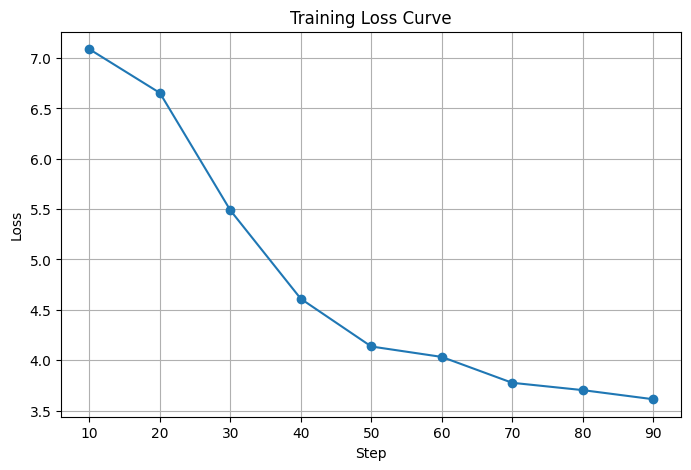

In [21]:
import matplotlib.pyplot as plt

#extract steps and losses
steps = [entry["step"] for entry in trainer.state.log_history if "loss" in entry]
losses = [entry["loss"] for entry in trainer.state.log_history if "loss" in entry]

#plot the training loss curve
plt.figure(figsize=(8,5))
plt.plot(steps, losses, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [25]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

#load base model and tokenizer
base_model_name = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
base_model = AutoModelForSeq2SeqLM.from_pretrained(base_model_name)

#load fine tuned model
fine_tuned_model_path = "/content/ChatDOC_finetuned"  # path where you saved fine-tuned model
fine_model = AutoModelForSeq2SeqLM.from_pretrained(fine_tuned_model_path)

# create pipelines
base_pipe = pipeline("text2text-generation", model=base_model, tokenizer=tokenizer)
fine_pipe = pipeline("text2text-generation", model=fine_model, tokenizer=tokenizer)


Device set to use cpu
Device set to use cpu


In [35]:
prompts = [
    "How to schedule a doctor appointment?",
    "What are the visiting hours for the hospital?",
    "How can I get my lab test results?",
    "Explain the procedure for blood donation.",
    "Can I reschedule my appointment online?",
    "What documents are needed for a health checkup?",
    "How do I contact the help desk?",
    "Is there a teleconsultation option available?",
    "How do I cancel an appointment?",
    "Provide tips for first-time hospital visitors.",
    "What vaccines are available for adults at the clinic?",
    "How do I prepare for a routine physical examination?",
    "Are there any online resources for managing chronic illnesses?",
    "What is the process to request a medical certificate?"
]


In [43]:
results = []

for prompt in prompts:
    try:
        #generate base model output
        base_output = base_pipe(
            prompt,
            max_new_tokens=80,
            do_sample=True,
            top_p=0.9,
            temperature=0.7,
            repetition_penalty=2.0,
            early_stopping=True
        )[0]['generated_text']

        #generate fine-tuned model output
        fine_output = fine_pipe(
            prompt,
            max_new_tokens=80,
            do_sample=True,
            top_p=0.9,
            temperature=0.7,
            repetition_penalty=2.0,
            early_stopping=True
        )[0]['generated_text']

    except Exception as e:
        base_output = f"Error generating output: {e}"
        fine_output = f"Error generating output: {e}"


    results.append({
        "prompt": prompt,
        "base_model_output": base_output,
        "fine_tuned_output": fine_output
    })

    # Print outputs
    print(f"Prompt: {prompt}")
    print(f"Base Model Output: {base_output}")
    print(f"Fine-Tuned Output: {fine_output}")
    print("-" * 80)





Prompt: How to schedule a doctor appointment?
Base Model Output: Schedule a doctor's appointment with your doctor.
Fine-Tuned Output: If you want to schedule a doctor's appointment, call the office of your doctor and ask for a referral.
--------------------------------------------------------------------------------
Prompt: What are the visiting hours for the hospital?
Base Model Output: 8:00 am - 10:00 pm
Fine-Tuned Output: 6:00 AM to 10:00 AM
--------------------------------------------------------------------------------
Prompt: How can I get my lab test results?
Base Model Output: Get a sample of your lab test results.
Fine-Tuned Output: If you have a lab test, you may need to get the results of your lab tests.
--------------------------------------------------------------------------------
Prompt: Explain the procedure for blood donation.
Base Model Output: Blood donation is a procedure that requires the blood to be removed from the body.
Fine-Tuned Output: Blood donation is a for

In [44]:
#save outputs in a text file
with open("sample_outputs.txt", "w") as f:
    for r in results:
        f.write(f"Prompt: {r['prompt']}\n")
        f.write(f"Base Model Output: {r['base_model_output']}\n")
        f.write(f"Fine-Tuned Output: {r['fine_tuned_output']}\n")
        f.write("-"*60 + "\n")

print("sample outputs saved successfully")


sample outputs saved successfully
